In [1]:
# Imports

import sys
sys.path.append("../")
import numpy
import matplotlib
from tensorflow import keras

from classes.modelWrapperClass import ModelWrapper
from classes.dataLoaderClass import DataLoader
from classes.linearFitClass import LinearFit
from classes.plottingClass import Plotting
from classes.clusterClass import Cluster

#Interactive matplotlib plots
%matplotlib widget

2024-11-21 10:07:46.037487: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Initialisation

modelAPI = ModelWrapper(keras.models.load_model("./models/3D/M1", compile=False))
#modelAPI.model.summary()
data_loader = DataLoader("./data")

noisy = data_loader.getBatch(experimental=True, noisy=True, preprocessed=True)
noisy_with_E = data_loader.getBatch(experimental=True, noisy=True, preprocessed=False)
clean = data_loader.getBatch(experimental=True, noisy=False, preprocessed=True)
names = data_loader.getX17Names()

X17_noisy = data_loader.getBatch(True, True, preprocessed=True)[100:]	# Events 0-100 are used for event generator calibration and other stuff, so these are excluded from validation data
X17_noisy_with_E = data_loader.getBatch(True, True, preprocessed=False)[100:]
X17_nonNN = data_loader.getBatch(True,False)[100:]
X17_names = data_loader.getX17Names()[100:]
X17_reconstructions = modelAPI.evaluateBatch(X17_noisy) #* X17_noisy

calib_noisy = data_loader.getBatch(True, True, preprocessed=True)[:100]
calib_noisy_with_E = data_loader.getBatch(True, True, preprocessed=False)[:100]
calib_nonNN = data_loader.getBatch(True,False)[:100]
calib_names = data_loader.getX17Names()[:100]
calib_reconstructions = modelAPI.evaluateBatch(calib_noisy)

cmap = matplotlib.pyplot.get_cmap("Greys")
cmap.set_under('cyan')

def upsample(event):
	return numpy.repeat(numpy.repeat(event, 10, axis=0), 10, axis=1)[:100,:120,:200]	# for accurate visualisation

2024-11-21 10:07:51.125659: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


4/4 [==============================] - 1s 134ms/step


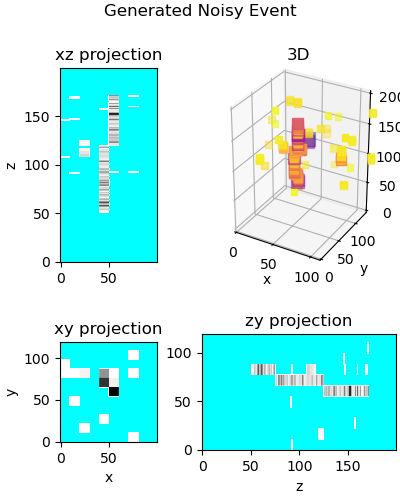

In [3]:
# View generated data
is_noisy = True

events = data_loader.getBatch(False, is_noisy, 0, preprocessed=False)
index = numpy.random.randint(0, events.shape[0])

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = Plotting.plot2DAnd3D(events[index], "Generated Noisy Event")
fig.set_size_inches(4,5)
matplotlib.pyplot.show()
#fig.savefig("imgs/paper/noisy_event.pdf")

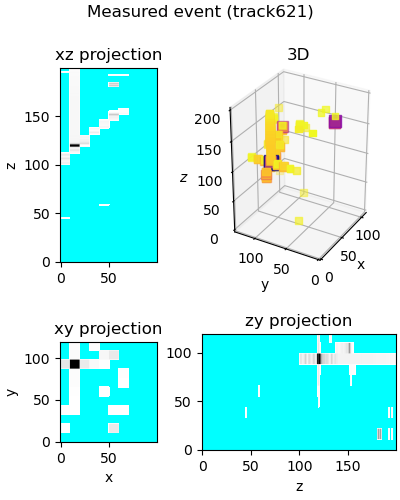

In [ ]:
# View measured data

index = numpy.random.choice(DataLoader.nice_track_indices)
#index=135	# view chimney removal by setting preprocessed=False vs. True
index=620
fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = Plotting.plot2DAnd3D(data_loader.getBatch(True,True,preprocessed=False)[index], "Measured event (track" + str(index+1) + ")", azimuth=-150)
fig.set_size_inches(4,5)
matplotlib.pyplot.show()

#fig.savefig("imgs/paper/crosstalk_noisy.pdf")

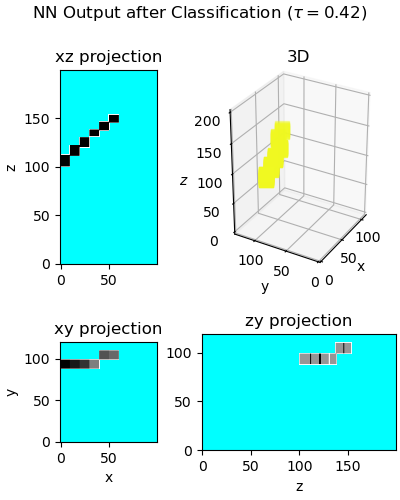

In [ ]:
# Show reconstruction
index = numpy.random.choice(DataLoader.nice_track_indices)
#index= 104 #508 363 513 424
index = 620

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)


#fig, ax = Plotting.plot2DAnd3D(X17_reconstructions[index-100], "NN Output before Classification", azimuth=-150)
#fig, ax = Plotting.plot2DAnd3D(numpy.where(X17_reconstructions[index-100]>0.42,1,0), r"NN Output after Classification ($\tau=0.42$)", azimuth=-150)
#fig, ax = Plotting.plot2DAnd3D(X17_nonNN[index-100], "nonNN Output", azimuth=-150)
fig.set_size_inches(4,5)
matplotlib.pyplot.show()

#fig.savefig("imgs/paper/crosstalk_rec.pdf")
#fig.savefig("imgs/paper/crosstalk_class.pdf")
#fig.savefig("imgs/paper/crosstalk_nonNN.pdf")

In [3]:
# Set classification threshold tau

modelAPI.threshold = 0.42
X17_classified = modelAPI.classify(X17_reconstructions)

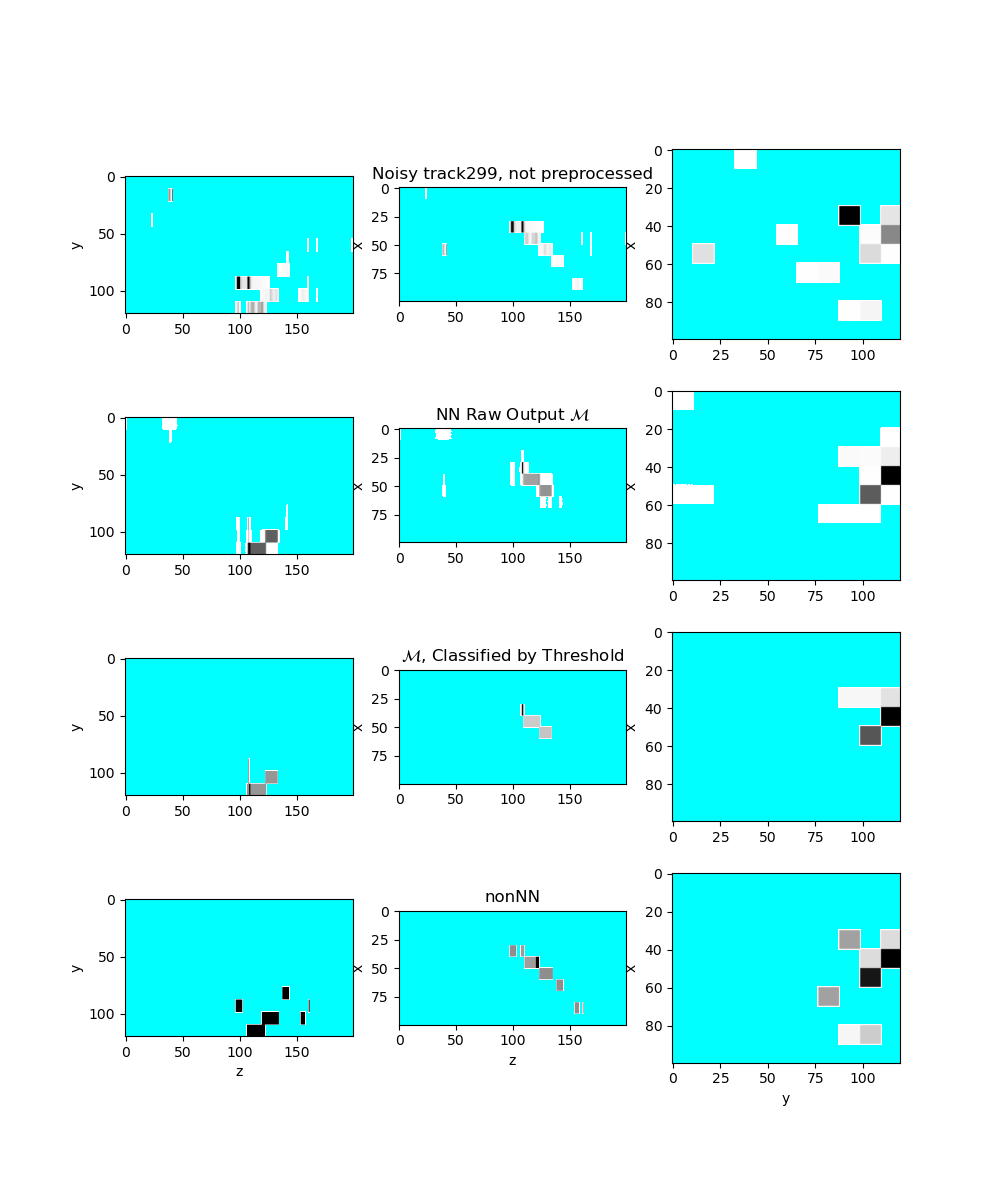

In [4]:
# View and compare reconstructions
#TODO in new plotting format

#index = numpy.random.randint(0, 642)
index = numpy.random.choice(DataLoader.nice_track_indices)
#index = 249
noisy_event = noisy_with_E[index]
#print(numpy.max(noisy_event))
preprocessed_event = noisy[index]
nonNN_reconstruction = numpy.where( clean[index] > 1e-6, 1, 0)
NN_raw_reconstruction = modelAPI.evaluateSingleEvent(preprocessed_event)
#NN_multiply_reconstruction = NN_raw_reconstruction * noisy_event
NN_classification = modelAPI.classify(NN_raw_reconstruction) 

def upsample(event):
	return numpy.repeat(numpy.repeat( numpy.copy(event) , 10, axis=0), 11, axis=1)[:100,:120,:200]

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(4,3)
fig.set_size_inches(10, 12)
#fig.tight_layout()
proj_type = ["zy","zx","yx"]

for axis in [0,1,2]:
	ax[0,axis].imshow(numpy.sum(upsample( noisy_event ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(noisy_event)])/2)
	ax[1,axis].imshow(numpy.sum(upsample( NN_raw_reconstruction ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(NN_raw_reconstruction)])/2)
	#ax[2,axis].imshow(numpy.sum(upsample( NN_multiply_reconstruction ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(NN_multiply_reconstruction)])/2)
	ax[2,axis].imshow(numpy.sum(upsample( NN_classification ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(NN_classification)])/2)
	ax[3,axis].imshow(numpy.sum(upsample( nonNN_reconstruction ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(nonNN_reconstruction)])/2)

	for j in range(4):
		ax[j,axis].set_ylabel(proj_type[axis][1])
	ax[-1,axis].set_xlabel(proj_type[axis][0])

ax[0,1].set_title("Noisy " + names[index] + ", not preprocessed")
ax[1,1].set_title(r"NN Raw Output $\mathcal{M}$")
#ax[2,1].set_title(r"$\text{Noisy} \cdot \mathcal{M}$")
ax[2,1].set_title(r"$\mathcal{M}$, Classified by Threshold")
ax[3,1].set_title("nonNN")
matplotlib.pyplot.show()

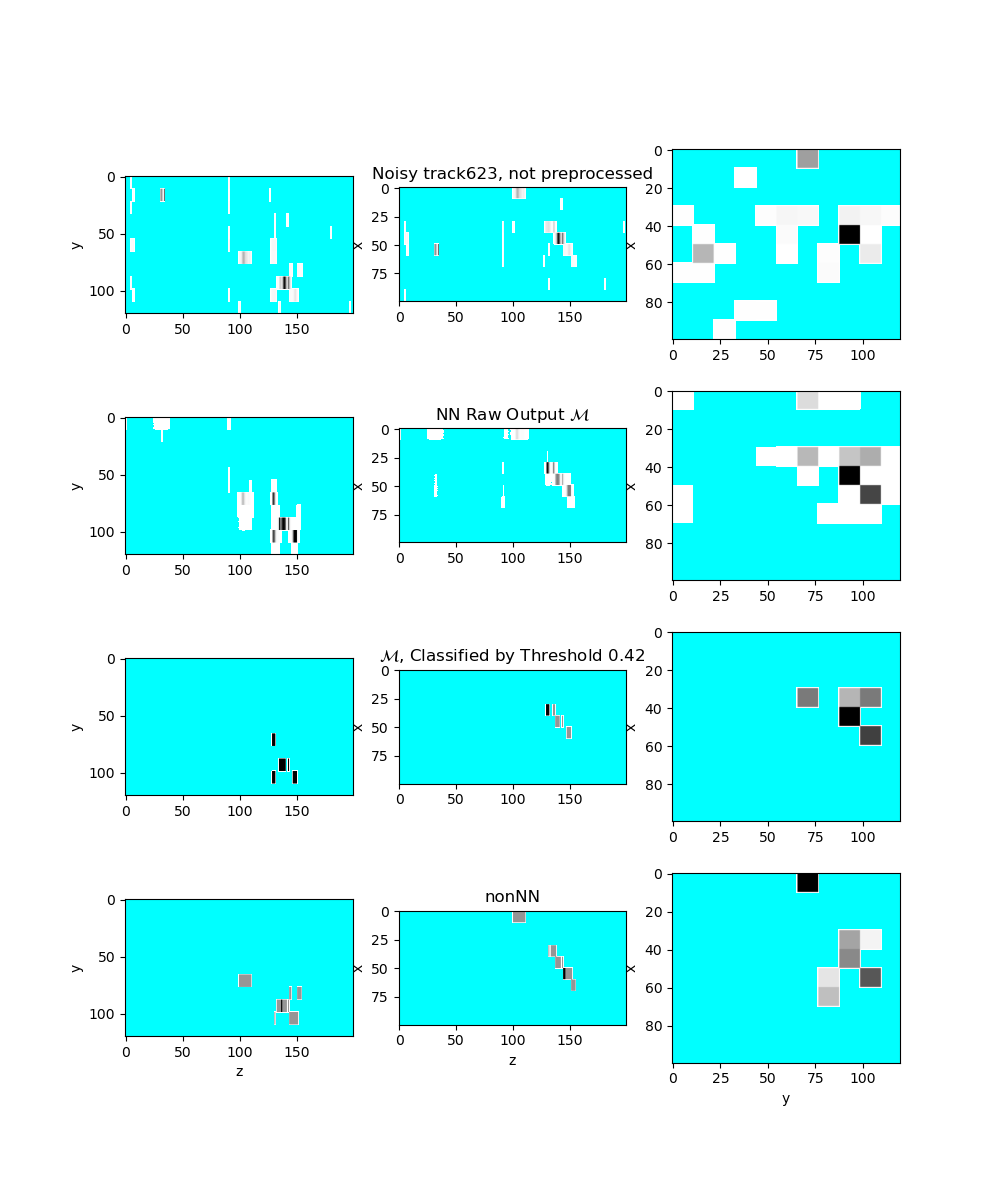

In [30]:
# Export crosstalks

crosstalk_indices = [103, 124, 139, 141, 142, 158, 174, 207, 225, 233, 257, 278, 287, 299, 336, 340, 398, 421, 423, 432, 436, 499, 511, 512, 515, 522, 528, 591, 596, 597, 615, 620, 621, 622]	# Visually found

for index in crosstalk_indices:
	noisy_event = noisy_with_E[index]
	preprocessed_event = noisy[index]
	nonNN_reconstruction = numpy.where( clean[index] > 1e-6, 1, 0)
	NN_raw_reconstruction = modelAPI.evaluateSingleEvent(preprocessed_event)
	NN_classification = modelAPI.classify(NN_raw_reconstruction) 

	def upsample(event):
		return numpy.repeat(numpy.repeat( numpy.copy(event) , 10, axis=0), 11, axis=1)[:100,:120,:200]

	fig = matplotlib.pyplot.gcf()
	matplotlib.pyplot.close(fig)

	fig, ax = matplotlib.pyplot.subplots(4,3)
	fig.set_size_inches(10, 12)
	#fig.tight_layout()
	proj_type = ["zy","zx","yx"]

	for axis in [0,1,2]:
		ax[0,axis].imshow(numpy.sum(upsample( noisy_event ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(noisy_event)])/2)
		ax[1,axis].imshow(numpy.sum(upsample( NN_raw_reconstruction ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(NN_raw_reconstruction)])/2)
		#ax[2,axis].imshow(numpy.sum(upsample( NN_multiply_reconstruction ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(NN_multiply_reconstruction)])/2)
		ax[2,axis].imshow(numpy.sum(upsample( NN_classification ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(NN_classification)])/2)
		ax[3,axis].imshow(numpy.sum(upsample( nonNN_reconstruction ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(nonNN_reconstruction)])/2)

		for j in range(4):
			ax[j,axis].set_ylabel(proj_type[axis][1])
		ax[-1,axis].set_xlabel(proj_type[axis][0])

	ax[0,1].set_title("Noisy " + names[index] + ", not preprocessed")
	ax[1,1].set_title(r"NN Raw Output $\mathcal{M}$")
	#ax[2,1].set_title(r"$\text{Noisy} \cdot \mathcal{M}$")
	ax[2,1].set_title(r"$\mathcal{M}$, Classified by Threshold " + str(modelAPI.threshold))
	ax[3,1].set_title("nonNN")
	fig.savefig("imgs/crosstalks/" + str(index) + ".png")

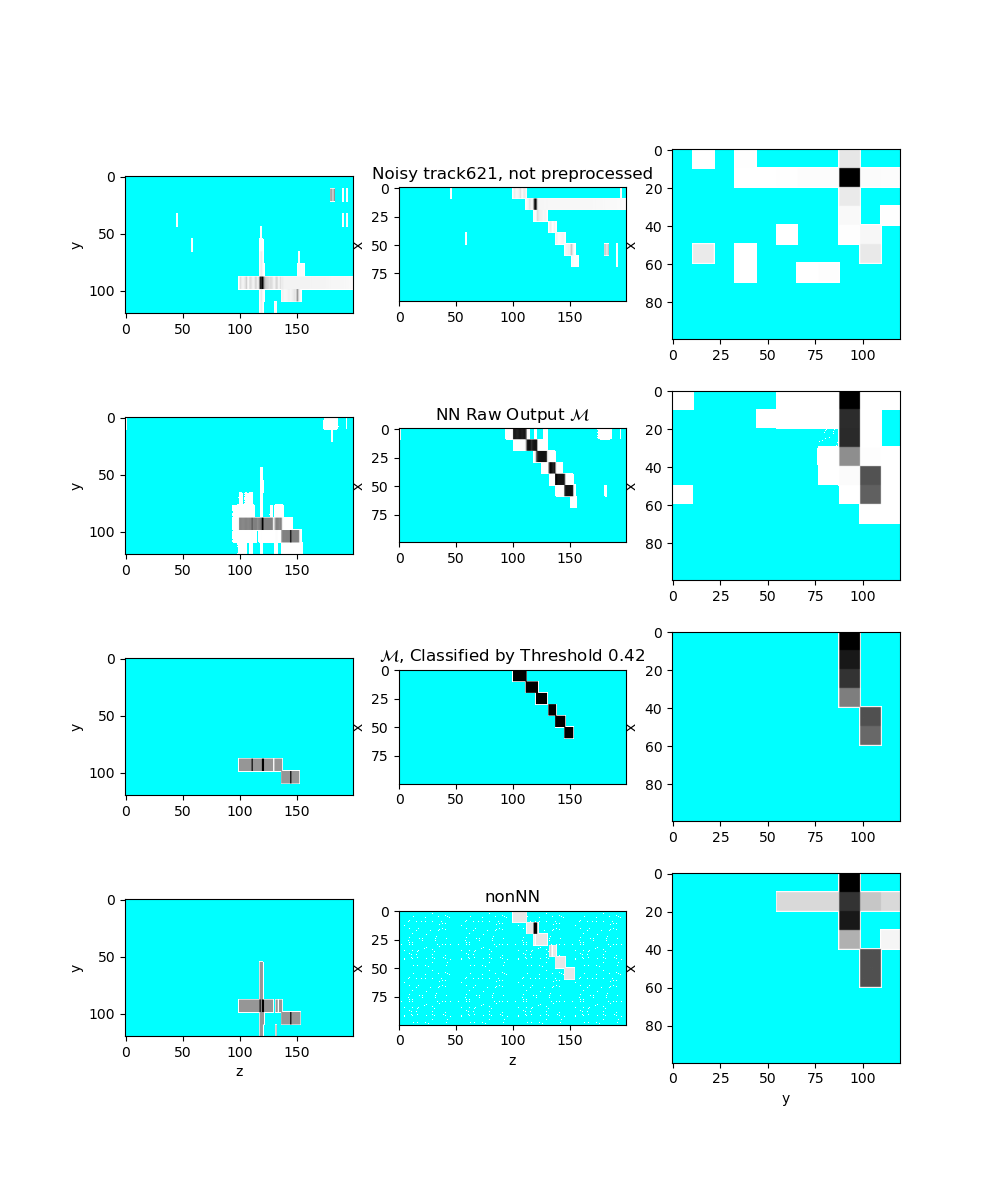

In [31]:
# Crosstalk example

crosstalk_indices = [103, 124, 139, 141, 142, 158, 174, 207, 225, 233, 257, 278, 287, 299, 336, 340, 398, 421, 423, 432, 436, 499, 511, 512, 515, 522, 528, 591, 596, 597, 615, 620, 621, 622]	# Visually found
index = numpy.random.choice(crosstalk_indices)

noisy_event = noisy_with_E[index]
preprocessed_event = noisy[index]
nonNN_reconstruction = numpy.where( clean[index] > 1e-6, 1, 0)
NN_raw_reconstruction = modelAPI.evaluateSingleEvent(preprocessed_event)
NN_classification = modelAPI.classify(NN_raw_reconstruction) 
def upsample(event):
	return numpy.repeat(numpy.repeat( numpy.copy(event) , 10, axis=0), 11, axis=1)[:100,:120,:200]
fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)
fig, ax = matplotlib.pyplot.subplots(4,3)
fig.set_size_inches(10, 12)
#fig.tight_layout()
proj_type = ["zy","zx","yx"]
for axis in [0,1,2]:
	ax[0,axis].imshow(numpy.sum(upsample( noisy_event ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(noisy_event)])/2)
	ax[1,axis].imshow(numpy.sum(upsample( NN_raw_reconstruction ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(NN_raw_reconstruction)])/2)
	#ax[2,axis].imshow(numpy.sum(upsample( NN_multiply_reconstruction ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(NN_multiply_reconstruction)])/2)
	ax[2,axis].imshow(numpy.sum(upsample( NN_classification ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(NN_classification)])/2)
	ax[3,axis].imshow(numpy.sum(upsample( nonNN_reconstruction ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(nonNN_reconstruction)])/2)
	for j in range(4):
		ax[j,axis].set_ylabel(proj_type[axis][1])
	ax[-1,axis].set_xlabel(proj_type[axis][0])
ax[0,1].set_title("Noisy " + names[index] + ", not preprocessed")
ax[1,1].set_title(r"NN Raw Output $\mathcal{M}$")
#ax[2,1].set_title(r"$\text{Noisy} \cdot \mathcal{M}$")
ax[2,1].set_title(r"$\mathcal{M}$, Classified by Threshold " + str(modelAPI.threshold))
ax[3,1].set_title("nonNN")
matplotlib.pyplot.show()

In [5]:
# Compare recognition with ground truth

def parseGroundTruthLine(line :str) -> tuple[str, int]:
	index = line.find("	")
	name = line[:index-1]
	line = line[index+1:]
	label_hugo = int( line[:index] )
	return (name, label_hugo)

def compareGroundTruth(events :numpy.ndarray, goodCriterionFunction, skip_calibration :bool = True) -> tuple[int, list[int], list[int], list[int]]:
	num_tracks, found_tracks, unfound_tracks, false_positives = 0, [], [], []

	with open("./labels.txt", 'r') as f:
		f.readline()	# skip the heading

		if skip_calibration:
			for _ in range(100):
				f.readline()
		
		i = 0
		for line in f.readlines():
			name, label_hugo = parseGroundTruthLine(line)
			if goodCriterionFunction(events[i]):
				if label_hugo > 0:
					found_tracks.append(i)
					num_tracks += 1
				else:	
					false_positives.append(i)
			else:
				if label_hugo > 0:
					num_tracks += 1
					unfound_tracks.append(i)
			i += 1
	
	return num_tracks, found_tracks, unfound_tracks, false_positives

In [9]:
# Flagging compared with handmade labels

def isLabeledGood(event):
	# Pad screen
	if numpy.any(event > 0):
		xs, ys, zs = numpy.nonzero(event)
		visited_pads = {}
		for i in range(xs.shape[0]):
			visited_pads[(xs[i], ys[i])] = 1
		if len(visited_pads) >= 2 or len(zs) >= 20:	return True
	return False

num_tracks, found_tracks_NN, unfound_tracks_NN, false_positives_NN = compareGroundTruth(X17_classified, isLabeledGood, skip_calibration=True)
_, found_tracks_nonNN, unfound_tracks_nonNN, false_positives_nonNN = compareGroundTruth(X17_nonNN, isLabeledGood, skip_calibration=True)

print("Number of tracks:", num_tracks)
print("nonNN: eff (true positives):", len(found_tracks_nonNN) / num_tracks, "   false positive rate:", len(false_positives_nonNN) / (len(false_positives_nonNN)+num_tracks))
print("NN: eff (true positives):", len(found_tracks_NN) / num_tracks, "   false positive rate:", len(false_positives_NN) / (len(false_positives_NN)+num_tracks))
print("NN did not found:", unfound_tracks_NN)
print("NN FPs:", false_positives_NN)

Number of tracks: 180
nonNN: eff (true positives): 1.0    false positive rate: 0.36619718309859156
NN: eff (true positives): 1.0    false positive rate: 0.29961089494163423
NN did not found: []
NN FPs: [2, 10, 22, 30, 43, 44, 51, 57, 61, 68, 69, 70, 78, 80, 88, 92, 97, 103, 110, 115, 116, 122, 125, 127, 133, 136, 137, 146, 152, 154, 156, 162, 165, 181, 185, 191, 205, 207, 214, 218, 229, 241, 244, 247, 255, 259, 278, 308, 309, 321, 334, 336, 337, 348, 358, 371, 382, 383, 389, 392, 401, 419, 430, 445, 451, 453, 458, 468, 478, 483, 498, 499, 506, 510, 511, 519, 530]


Smallest L2 distance threshold: 0.9850753768844221 (point (FPR, eff) = (0.1891891891891892, 0.9166666666666666) )
Best eff=1 threshold: 0.42366834170854273 (point (FPR, eff) = (0.29961089494163423, 1.0) )


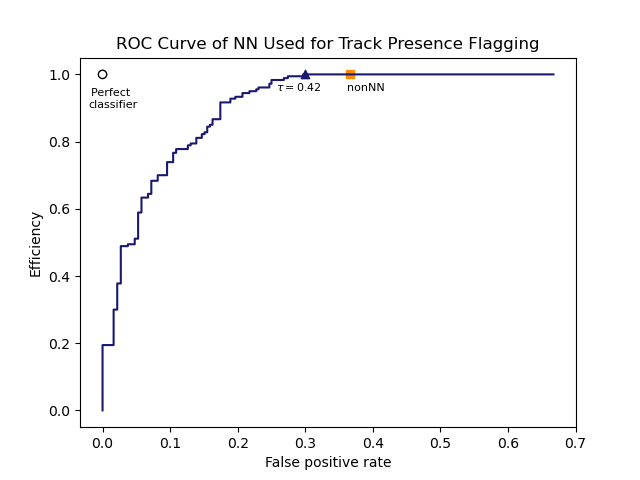

In [8]:
# ROC curve on validation dataset

def isLabeledGood(event):
	# At least pad screen
	if numpy.any(event > 0):
		xs, ys, zs = numpy.nonzero(event)
		visited_pads = {}
		for i in range(xs.shape[0]):
			visited_pads[(xs[i], ys[i])] = 1
		if len(visited_pads) >= 2 or len(zs) >= 20:	return True
	return False


thresholds = numpy.concatenate( [numpy.linspace(0,0.01,200), numpy.linspace(0.01,0.99,200), numpy.linspace(0.99,1,200)] )
n = thresholds.shape[0]

# Count nonNN eff and FP and also NN eff and FP for individual classification thresholds
num_tracks, found_nonNN, _, FP_nonNN = compareGroundTruth(X17_nonNN, isLabeledGood, skip_calibration=True)
num_found_nonNN , num_FP_nonNN= len(found_nonNN), len(FP_nonNN)
nums_found_NN, nums_FP_NN = [0]*n, [0]*n
for i in range(n):
	classified_events = numpy.where(X17_reconstructions > thresholds[i], 1, 0)
	_, found, _, FP = compareGroundTruth(classified_events, isLabeledGood, skip_calibration=True)
	nums_found_NN[i], nums_FP_NN[i] = len(found), len(FP)

NN_FPRs = [fp / (num_tracks + fp) for fp in nums_FP_NN]
nonNN_FPR = num_FP_nonNN / (num_tracks + num_FP_nonNN)
NN_effs = [num_found / num_tracks for num_found in nums_found_NN]
nonNN_eff = num_found_nonNN / num_tracks


# Threshold closest to (0,1)
def distance(fp, eff):
	return fp**2 + (eff-1)**2	#L2

optimal_threshold, best_dist, optimal_index = -1, numpy.infty, -1
for j in range(n):
	dist = distance(NN_FPRs[j], NN_effs[j])
	if dist < best_dist:
		optimal_index = j
		optimal_threshold = thresholds[j]
		best_dist = dist
print("Smallest L2 distance threshold:", optimal_threshold, "(point (FPR, eff) = (" + str(NN_FPRs[optimal_index]) + ", " + str(NN_effs[optimal_index]) + ") )")

# First threshold with efficiency one
optimal_threshold = -1
for j in range(n-1,-1,-1):
	if NN_effs[j] == 1:
		optimal_threshold = thresholds[j]
		break
print("Best eff=1 threshold:", optimal_threshold, "(point (FPR, eff) = (" + str(NN_FPRs[j]) + ", " + str(NN_effs[j]) + ") )")


# Plot ROC
fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(1)
ax.plot(NN_FPRs, NN_effs, color="midnightblue", drawstyle="steps-post")
ax.scatter([nonNN_FPR], [nonNN_eff], marker="s" , color="darkorange")
ax.annotate("nonNN", (nonNN_FPR, nonNN_eff), xytext=(nonNN_FPR-0.005, nonNN_eff-0.05), fontsize=8)	# nonNN
ax.scatter([NN_FPRs[j]], [NN_effs[j]], marker="^", color="midnightblue")
ax.annotate(r"$\tau = 0.42$", (NN_FPRs[j], NN_effs[j]), xytext=(NN_FPRs[j]-0.043, NN_effs[j]-0.05), fontsize=8)	# eff=1
ax.scatter([0], [1], marker="o", facecolors="none", color="black")
ax.annotate("Perfect \nclassifier", (0, 1), xytext=(0.015, 1-0.1), fontsize=8, horizontalalignment="center")	# perfect classifier
ax.set_xlabel("False positive rate")
ax.set_ylabel("Efficiency")
ax.set_title("ROC Curve of NN Used for Track Presence Flagging")
matplotlib.pyplot.show()

#fig.savefig("./imgs/paper/ROC_hugoFP.pdf")

In [6]:
# Flagging intersections

def isLabeledGood(event):
	# At least pad screen
	if numpy.any(event > 0):
		xs, ys, zs = numpy.nonzero(event)
		visited_pads = {}
		for i in range(xs.shape[0]):
			visited_pads[(xs[i], ys[i])] = 1
		if len(visited_pads) >= 2 or len(zs) >= 20:	return True
	return False

threshold = 0.42

N = X17_reconstructions.shape[0]
classified_events = numpy.where(X17_reconstructions > threshold, 1, 0)
num_tracks, found_tracks_NN, unfound_tracks_NN, false_positives_NN = compareGroundTruth(classified_events, isLabeledGood, skip_calibration=True)
_, found_tracks_nonNN, unfound_tracks_nonNN, false_positives_nonNN = compareGroundTruth(X17_nonNN, isLabeledGood, skip_calibration=True)

def getIntersection(NN, nonNN, use_tracks):
	ls_NN = found_tracks_NN if use_tracks else false_positives_NN
	ls_nonNN = found_tracks_nonNN if use_tracks else false_positives_nonNN
	return [j for j in range(N) if ( (NN and j in ls_NN) or (not NN and j not in ls_NN) )
			and ( (nonNN and j in ls_nonNN) or (not nonNN and j not in ls_nonNN) )]

print("NN & nonNN IN FOUND TRACKS:", len(getIntersection(True, True, True)))
print("NN & nonNN IN FPS:", len(getIntersection(True,True,False)))
print("NN & NOT nonNN IN FPS:", len(getIntersection(True,False,False)))
print("NOT NN & nonNN IN FPS:", len(getIntersection(False,True,False)))
print("NOT NN & NOT nonNN IN FOUND TRACKS:", len(getIntersection(False,False,True)))
print("NN & NOT nonNN IN FOUND TRACKS:", len(getIntersection(True,False,True)))
print("NOT NN & nonNN IN FOUND TRACKS:", len(getIntersection(False,True,True)))
print("NOT NN & NOT nonNN IN FPS:", len(getIntersection(False,False,False)))
print("Eff:",len(found_tracks_NN)/num_tracks)
print("FP:",len(false_positives_NN)/(len(false_positives_NN) + num_tracks))

NN & nonNN IN FOUND TRACKS: 180
NN & nonNN IN FPS: 71
NN & NOT nonNN IN FPS: 6
NOT NN & nonNN IN FPS: 33
NOT NN & NOT nonNN IN FOUND TRACKS: 361
NN & NOT nonNN IN FOUND TRACKS: 0
NOT NN & nonNN IN FOUND TRACKS: 0
NOT NN & NOT nonNN IN FPS: 431
Eff: 1.0
FP: 0.29961089494163423


Tile number: 41
Ratio of tiles on line fit: 1.0
Average distance from line fit: 0.28745906225074414
Missing tiles: 24


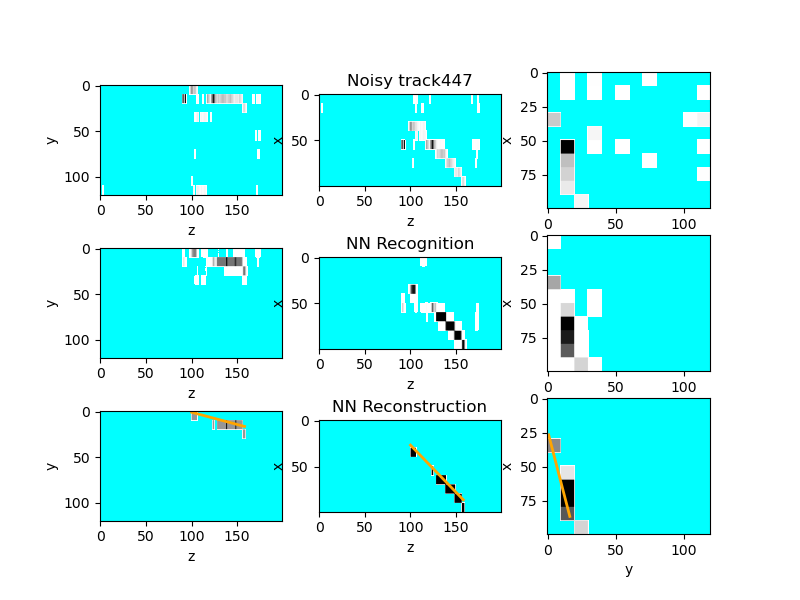

In [7]:
# Line fit analysis example
modelAPI.threshold = 0.42

index = numpy.random.choice(data_loader.nice_track_indices)
#index = numpy.random.randint(0,641)
#index=609
event = data_loader.getBatch(True,True)[index]
rec = modelAPI.evaluateSingleEvent(event)
result = modelAPI.classify(rec)
name = data_loader.getX17Names()[index]
in_temporal_space = False	# Whether fitting happens in (x,y,t) or (x,y,z)

lin_fit = LinearFit(result, in_temporal_space)

outliers = lin_fit.getOutliers()
mean_residuum = lin_fit.getMeanResiduum()
missing_tiles = lin_fit.getMissingTiles(event, in_temporal_space)

print("Tile number:", len(lin_fit.coords))
print("Ratio of tiles on line fit:", 1 - len(outliers)/len(lin_fit.coords))
print("Average distance from line fit:", mean_residuum)
print("Missing tiles:", len(missing_tiles))

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(3,3)
fig.set_size_inches(8, 6)
#fig.tight_layout()
proj_type = ["zy","zx","yx"]
proj_indices = [(2,1), (2,0), (1,0)]

for axis in [0,1,2]:
	ax[0,axis].imshow(numpy.sum(upsample( event ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(event)])/2)
	ax[1,axis].imshow(numpy.sum(upsample( rec ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(rec)])/2)
	ax[2,axis].imshow(numpy.sum(upsample( result ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(result)])/2)
	a, b = (10*lin_fit.start[0], 11*lin_fit.start[1], (1 if in_temporal_space else 10)*lin_fit.start[2]), (10*lin_fit.end[0], 11*lin_fit.end[1], (1 if in_temporal_space else 10)*lin_fit.end[2])
	k, l = proj_indices[axis][0], proj_indices[axis][1]
	ax[2,axis].plot( [a[k], b[k]], [a[l], b[l]], linewidth=2, color="orange" )

	for j in range(3):
		ax[j,axis].set_ylabel(proj_type[axis][1])
		ax[j,axis].set_xlabel(proj_type[axis][0])

ax[0,1].set_title("Noisy " + name)
ax[1,1].set_title("NN Recognition")
ax[2,1].set_title("NN Reconstruction")

matplotlib.pyplot.show()

In [15]:
# Linear analysis support functions

def isLabeledGood(event):
	# At least pad screen
	if numpy.any(event > 0):
		xs, ys, zs = numpy.nonzero(event)
		visited_pads = {}
		for i in range(xs.shape[0]):
			visited_pads[(xs[i], ys[i])] = 1
		if len(visited_pads) >= 2 or len(zs) >= 20:	return True
	return False

def getLinearlyFittableIndices(events :numpy.ndarray, outliers_threshold :float, in_temporal_space :bool = True):
	fittable_indices = []
	for i in range(events.shape[0]):
		event = events[i]
		
		if isLabeledGood(event):
			lin_fit = LinearFit(event, in_temporal_space)
			if lin_fit.getRatioOutliers() <= outliers_threshold:
				fittable_indices.append(i)
	return fittable_indices

def getMeanLinearVals(events :numpy.ndarray, noisy_events :numpy.ndarray, in_temporal_space :bool = True) -> tuple[float, float, float]:
	ratios_outliers = []
	total_residuum = 0
	total_tile_num = 0
	total_missing_tiles = 0
		
	for i in range(events.shape[0]):
		event, noisy_event = events[i], noisy_events[i]
		lin_fit = LinearFit(event, in_temporal_space)

		ratios_outliers.append( lin_fit.getRatioOutliers() )
		total_residuum += lin_fit.getTotalResiduum()
		total_tile_num += len(lin_fit.coords)
		total_missing_tiles += len( lin_fit.getMissingTiles(noisy_event, in_temporal_space=in_temporal_space) )
	
	return (sum(ratios_outliers) / len(ratios_outliers), total_residuum / total_tile_num, total_missing_tiles / events.shape[0])

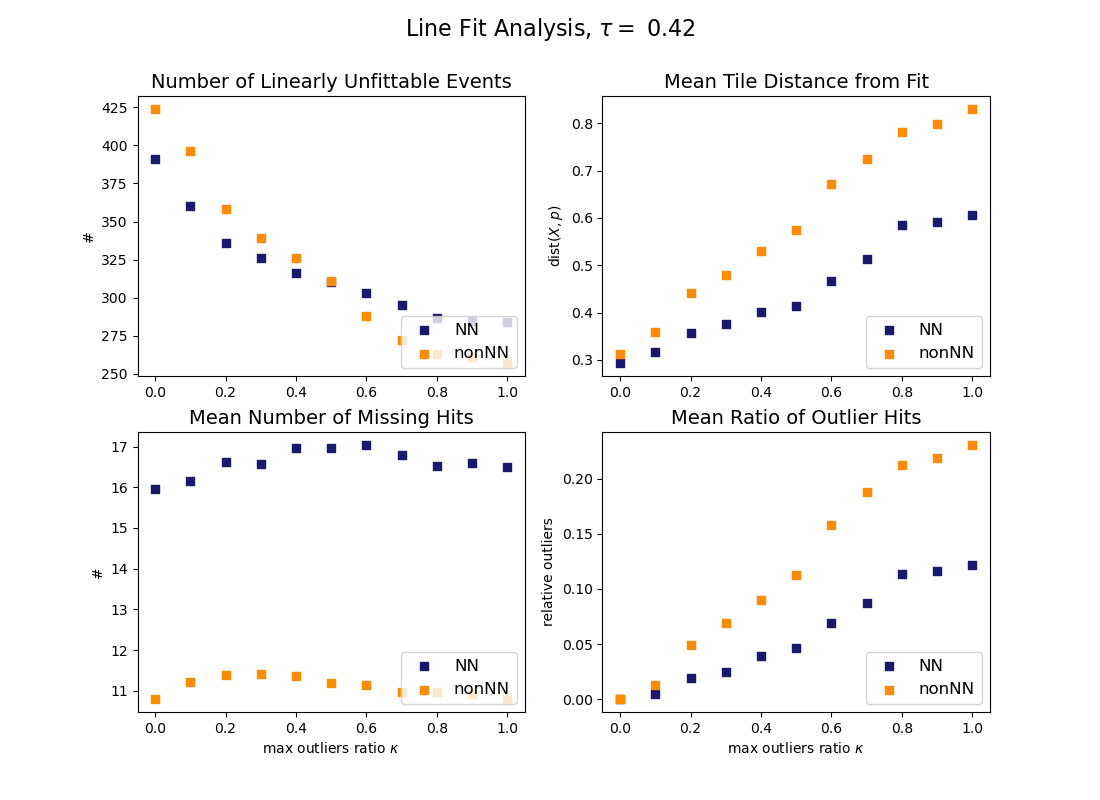

In [23]:
# Line fit analysis for variable kappa (max ratio of outliers)

modelAPI.threshold = 0.42
NN_classifications = modelAPI.classify(X17_reconstructions)
thresholds_outliers = numpy.linspace(0, 1, 11)
in_temporal_space = False

NN_results = {"outliers": [], "residua": [], "missing_tiles": [], "counts_fittable": [], "counts_unfittable": []}
nonNN_results = {"outliers": [], "residua": [], "missing_tiles": [], "counts_fittable": [], "counts_unfittable": []}

for threshold_outliers in thresholds_outliers:
	nonNN_fittable_indices = getLinearlyFittableIndices(X17_nonNN, threshold_outliers, in_temporal_space)
	NN_fittable_indices = getLinearlyFittableIndices(NN_classifications, threshold_outliers, in_temporal_space)
	
	# Fill fittable events counts data
	nonNN_results["counts_fittable"].append(len(nonNN_fittable_indices))
	NN_results["counts_fittable"].append(len(NN_fittable_indices))
	nonNN_results["counts_unfittable"].append(X17_nonNN.shape[0] - len(nonNN_fittable_indices))
	NN_results["counts_unfittable"].append(X17_nonNN.shape[0] - len(NN_fittable_indices))
	intersection_indices = [i for i in NN_fittable_indices if i in nonNN_fittable_indices]

	NN_ratio_outliers, NN_residuum, NN_missing_tiles = getMeanLinearVals(
		NN_classifications[intersection_indices], X17_noisy[intersection_indices], in_temporal_space
	)
	nonNN_ratio_outliers, nonNN_residuum, nonNN_missing_tiles = getMeanLinearVals(
		X17_nonNN[intersection_indices], X17_noisy[intersection_indices], in_temporal_space)

	# Fill other data
	NN_results["outliers"].append( NN_ratio_outliers )
	nonNN_results["outliers"].append( nonNN_ratio_outliers )
	NN_results["residua"].append( NN_residuum )
	nonNN_results["residua"].append( nonNN_residuum )
	NN_results["missing_tiles"].append( NN_missing_tiles )
	nonNN_results["missing_tiles"].append( nonNN_missing_tiles )

# Plot the result
fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(2,2)
fig.set_size_inches(11, 8)
#fig.tight_layout()

fig.suptitle(r"Line Fit Analysis, $\tau =$ " + str(modelAPI.threshold), fontsize=16)

ax[0,0].scatter(thresholds_outliers, (NN_results["counts_unfittable"]), label="NN", color="midnightblue", marker="s")
ax[0,0].scatter(thresholds_outliers, (nonNN_results["counts_unfittable"]), label="nonNN", color="darkorange", marker="s")
ax[0,0].legend(prop={'size': 12}, loc="lower right")
ax[0,0].set_title("Number of Linearly Unfittable Events", fontdict={"fontsize": 14})

ax[0,1].scatter(thresholds_outliers, NN_results["residua"], label="NN", color="midnightblue", marker="s")
ax[0,1].scatter(thresholds_outliers, nonNN_results["residua"], label="nonNN", color="darkorange", marker="s")
ax[0,1].legend(prop={'size': 12}, loc="lower right")
ax[0,1].set_title("Mean Tile Distance from Fit", fontdict={"fontsize": 14})

ax[1,0].scatter(thresholds_outliers, NN_results["missing_tiles"], label="NN", color="midnightblue", marker="s")
ax[1,0].scatter(thresholds_outliers, nonNN_results["missing_tiles"], label="nonNN", color="darkorange", marker="s")
ax[1,0].legend(prop={'size': 12}, loc="lower right")
ax[1,0].set_title("Mean Number of Missing Hits", fontdict={"fontsize": 14})

ax[1,1].scatter(thresholds_outliers, NN_results["outliers"], label="NN", color="midnightblue", marker="s")
ax[1,1].scatter(thresholds_outliers, nonNN_results["outliers"], label="nonNN", color="darkorange", marker="s")
ax[1,1].legend(prop={'size': 12}, loc="lower right")
ax[1,1].set_title("Mean Ratio of Outlier Hits", fontdict={"fontsize": 14})

ax[1,0].set_xlabel(r"max outliers ratio $\kappa$")
ax[1,1].set_xlabel(r"max outliers ratio $\kappa$")

ax[0,0].set_ylabel("#")
ax[0,1].set_ylabel(r"$\text{dist}(X,p)$")
ax[1,0].set_ylabel("#")
ax[1,1].set_ylabel("relative outliers")

matplotlib.pyplot.show()
#fig.savefig("imgs/paper/linear_analysis_tau0.1.pdf")

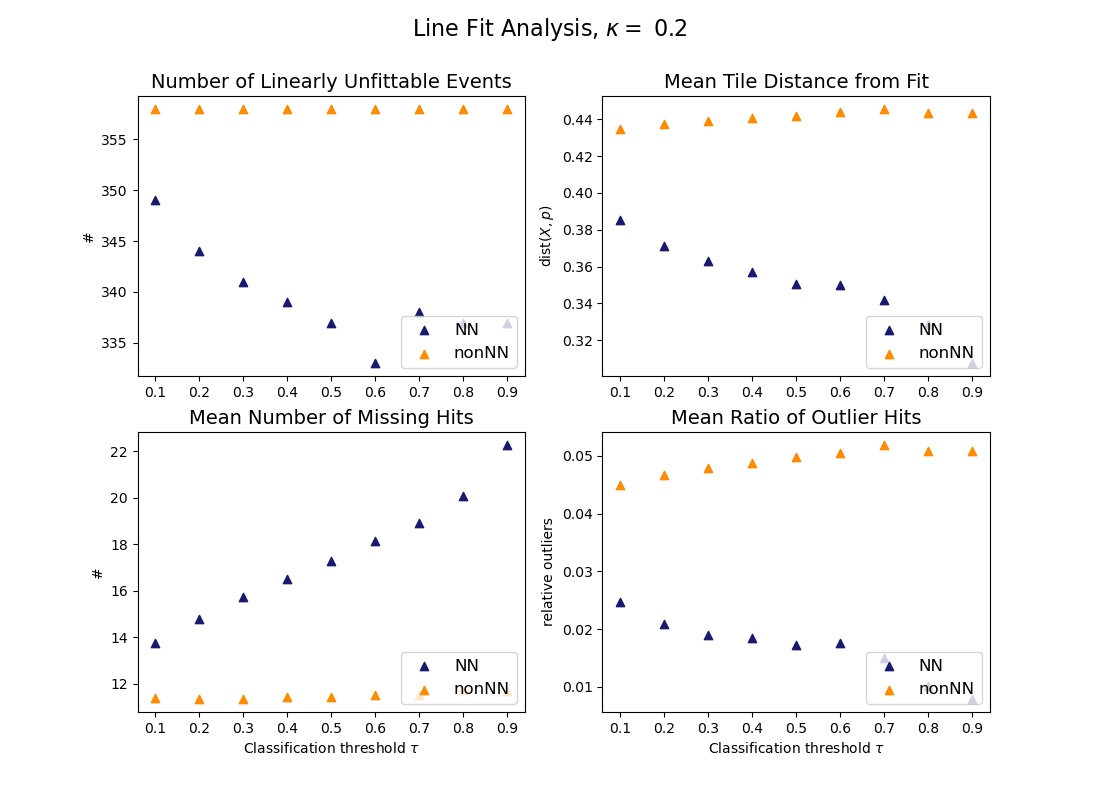

In [24]:
# Line fit analysis for variable tau (classification threshold)

threshold_outliers = 0.2
in_temporal_space = False

thresholds = numpy.linspace(0.1, 0.9, 9)

NN_results = {"outliers": [], "residua": [], "missing_tiles": [], "counts_fittable": [], "counts_unfittable": []}
nonNN_results = {"outliers": [], "residua": [], "missing_tiles": [], "counts_fittable": [], "counts_unfittable": []}

for tau in thresholds:
	modelAPI.threshold = tau
	NN_classifications = modelAPI.classify(X17_reconstructions)

	nonNN_fittable_indices = getLinearlyFittableIndices(X17_nonNN, threshold_outliers, in_temporal_space)
	NN_fittable_indices = getLinearlyFittableIndices(NN_classifications, threshold_outliers, in_temporal_space)
	
	# Fill fittable events counts data
	nonNN_results["counts_fittable"].append(len(nonNN_fittable_indices))
	NN_results["counts_fittable"].append(len(NN_fittable_indices))
	nonNN_results["counts_unfittable"].append(X17_nonNN.shape[0] - len(nonNN_fittable_indices))
	NN_results["counts_unfittable"].append(X17_nonNN.shape[0] - len(NN_fittable_indices))
	intersection_indices = [i for i in NN_fittable_indices if i in nonNN_fittable_indices]

	NN_ratio_outliers, NN_residuum, NN_missing_tiles = getMeanLinearVals(
		NN_classifications[intersection_indices], X17_noisy[intersection_indices], in_temporal_space
	)
	nonNN_ratio_outliers, nonNN_residuum, nonNN_missing_tiles = getMeanLinearVals(
		X17_nonNN[intersection_indices], X17_noisy[intersection_indices], in_temporal_space)

	# Fill other data
	NN_results["outliers"].append( NN_ratio_outliers )
	nonNN_results["outliers"].append( nonNN_ratio_outliers )
	NN_results["residua"].append( NN_residuum )
	nonNN_results["residua"].append( nonNN_residuum )
	NN_results["missing_tiles"].append( NN_missing_tiles )
	nonNN_results["missing_tiles"].append( nonNN_missing_tiles )

# Plot the result
fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(2,2)
fig.set_size_inches(11, 8)
#fig.tight_layout()

fig.suptitle(r"Line Fit Analysis, $\kappa =$ " + str(threshold_outliers), fontsize=16)

ax[0,0].scatter(thresholds, NN_results["counts_unfittable"], label="NN", color="midnightblue", marker="^")
ax[0,0].scatter(thresholds, nonNN_results["counts_unfittable"], label="nonNN", color="darkorange", marker="^")
ax[0,0].legend(prop={'size': 12}, loc="lower right")
ax[0,0].set_title("Number of Linearly Unfittable Events", fontdict={"fontsize": 14})

ax[0,1].scatter(thresholds, NN_results["residua"], label="NN", color="midnightblue", marker="^")
ax[0,1].scatter(thresholds, nonNN_results["residua"], label="nonNN", color="darkorange", marker="^")
ax[0,1].legend(prop={'size': 12}, loc="lower right")
ax[0,1].set_title("Mean Tile Distance from Fit", fontdict={"fontsize": 14})

ax[1,0].scatter(thresholds, NN_results["missing_tiles"], label="NN", color="midnightblue", marker="^")
ax[1,0].scatter(thresholds, nonNN_results["missing_tiles"], label="nonNN", color="darkorange", marker="^")
ax[1,0].legend(prop={'size': 12}, loc="lower right")
ax[1,0].set_title("Mean Number of Missing Hits", fontdict={"fontsize": 14})

ax[1,1].scatter(thresholds, NN_results["outliers"], label="NN", color="midnightblue", marker="^")
ax[1,1].scatter(thresholds, nonNN_results["outliers"], label="nonNN", color="darkorange", marker="^")
ax[1,1].legend(prop={'size': 12}, loc="lower right")
ax[1,1].set_title("Mean Ratio of Outlier Hits", fontdict={"fontsize": 14})

ax[1,0].set_xlabel(r"Classification threshold $\tau$")
ax[1,1].set_xlabel(r"Classification threshold $\tau$")

ax[0,0].set_ylabel("#")
ax[0,1].set_ylabel(r"$\text{dist}(X,p)$")
ax[1,0].set_ylabel("#")
ax[1,1].set_ylabel("relative outliers")

matplotlib.pyplot.show()
#fig.savefig("imgs/paper/linear_analysis_kappa0.2.pdf")

/home/gajdoma6/UTEF/track_denoiser/classes/clusterClass.py:197: RuntimeWarning: invalid value encountered in double_scalars
  self.energy_density = self.energy / self.effective_length
/tmp/ipykernel_553/2568334490.py:54: RuntimeWarning: invalid value encountered in double_scalars
  energy_densities.append(E / cluster.effective_length)


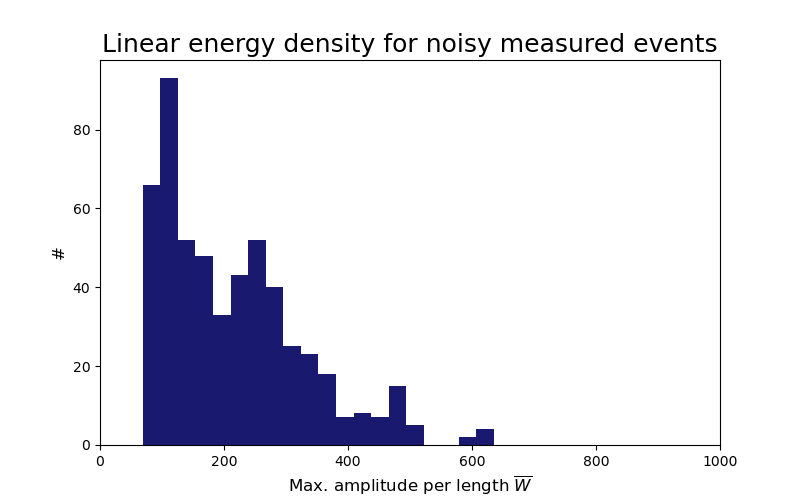

In [ ]:
#Four reconstruction energy histograms

modelAPI.threshold = 0.42
X17_classified = modelAPI.classify(X17_reconstructions)

def getEnergies(track_events, energy_events, make_clusters=False, eventCondition = lambda x: True, clusterCondition = lambda x: True):
	energy_densities = []

	for i in range(track_events.shape[0]):
		event = track_events[i]
		event_E = energy_events[i]
		if not eventCondition(event):	continue

		xs, ys, zs = numpy.nonzero(event)
		if len(xs) == 0:	continue

		if make_clusters:
			for cluster in Cluster.clusterise(event):
				if clusterCondition(cluster):
					cluster.setEnergy(event_E)
					#energy_densities.append(cluster.energy_density)
					
					# store maximal amplitude for each waveform
					pads_E = {}
					pads_L = {}
					for coord in cluster.coords:
						if coord[:2] not in pads_L:	pads_L[coord[:2]] = 0.1
						else:	pads_L[coord[:2]] += 0.1

						if coord[:2] not in pads_E or pads_E[coord[:2]] < event_E[coord]:
							pads_E[coord[:2]] = event_E[coord]
					E = sum(pads_E[pad] for pad in pads_E)

					#for pad in pads_E:	energy_densities.append(pads_E[pad] / pads_L[pad])
					energy_densities.append(E / cluster.effective_length)
		else:
			coords = ( list(xs), list(ys), list(zs) )
			coords = list(zip(*coords))
			cluster = Cluster(coords)
			cluster.setEnergy(event_E)

			# store maximal amplitude for each waveform
			pads_E = {}
			pads_L = {}
			for coord in cluster.coords:
				if coord[:2] not in pads_L:	pads_L[coord[:2]] = 0.1
				else:	pads_L[coord[:2]] += 0.1
				
				if coord[:2] not in pads_E or pads_E[coord[:2]] < event_E[coord]:
					pads_E[coord[:2]] = event_E[coord]
			E = sum(pads_E[pad] for pad in pads_E)

			#for pad in pads_E:	energy_densities.append(pads_E[pad] / pads_L[pad])
			energy_densities.append(E / cluster.effective_length)
	return energy_densities


make_clusters = False 
energies_noisy = getEnergies(X17_noisy, X17_noisy_with_E, make_clusters=make_clusters, clusterCondition=lambda x: len(x.coords) >= 0)
energies_nonNN = getEnergies(X17_nonNN, X17_noisy_with_E, make_clusters=make_clusters, clusterCondition=lambda x: len(x.coords) >= 0)
#good_indices = getLinearlyFittableIndices(X17_classified, 0.1, in_temporal_space)
#good_indices = [i-100 for i in data_loader.nice_track_indices]
#energies_NN = getEnergies(X17_classified[good_indices], X17_noisy_with_E[good_indices], make_clusters=False, clusterCondition=lambda x: len(x.coords) >= 0)
energies_NN = getEnergies(X17_classified, X17_noisy_with_E, make_clusters=make_clusters, clusterCondition=lambda x: len(x.coords) >= 0)

j = 1
energies = [energies_noisy, energies_NN, energies_nonNN]
titles = ["Linear energy density for noisy measured events", "Linear energy density after NN recognition (N = " + str(len(energies[j])) + ")", "Linear energy density after nonNN recognition"]

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(1)
fig.set_size_inches(8, 5)

counts, bins, _ = ax.hist(energies[j], bins=20, histtype="stepfilled", color="midnightblue", label="Data")
ax.set_xlim(0,1000)
ax.set_ylabel("#", fontsize=12)
ax.set_title(titles[j], fontsize=18)
ax.set_xlabel(r"Max. amplitude per length $\overline{W}$", fontsize=12)

#xs = [i for i in range(900)]
#ys = []
#fit_landau_f = open("landau.txt", "r")
#for line in fit_landau_f.readlines():
#	ys.append(float(line))
#ax.plot(xs, ys, color="darkorange", label="Landau fit")
#ax.legend()

matplotlib.pyplot.show()
#fig.savefig("imgs/paper/E_L_NN_nofit.pdf")

